# Do a PCA decomposition of the Pickles library

This can be done in a variety of ways - depending on what data we focus on.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import pandas as pd
import seaborn as sns

%matplotlib inline

## Loading of the library of spectra

The spectra are stored in a FITS file in the Pickles subdirectory called `pickles-spectra.fits`. This contains the wavelength axis in the first HDU, the flux in the next and the flux uncertainty in the last. But we also need to get the overview table which has the classification of the spectra.

In [8]:
def load_pickles_library():
    hdul = fits.open('../../../Datafiles/pickles-spectra.fits')
    wave = hdul[0].data
    flux = hdul[1].data
    dflux = hdul[2].data
    
    return wave, flux, dflux

def load_overview_table():
    return Table().read('../../../Datafiles/overview-of-spectra.vot')

In [9]:
wave, flux, dflux = load_pickles_library()
t_overview = load_overview_table()

## Examining a few spectra

Let us here plot the first spectrum in each class.

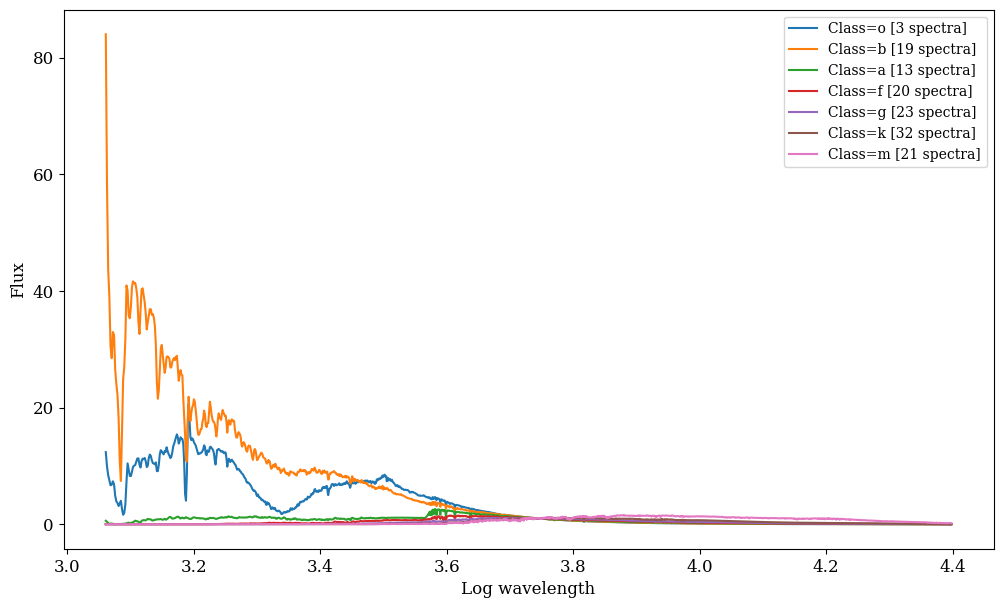

In [10]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,7))

MKclasses = ['o', 'b', 'a', 'f', 'g', 'k', 'm']
for MK in MKclasses:
    ii, = np.where(t_overview['SPType'] == MK)
    
    ax.plot(np.log10(wave), flux[:, ii[0]], label='Class={0} [{1} spectra]'.format(MK, len(ii)))
    
ax.set_xlabel('Log wavelength')
ax.set_ylabel('Flux')
ax.legend()

But of course that is not a very nice illustration. So let us focus on the optical region

In [11]:
i_optical, = np.where((wave > 3000) & (wave < 10000))
flux_opt = flux[i_optical, :]
dflux_opt = dflux[i_optical, :]
wave_opt = wave[i_optical]

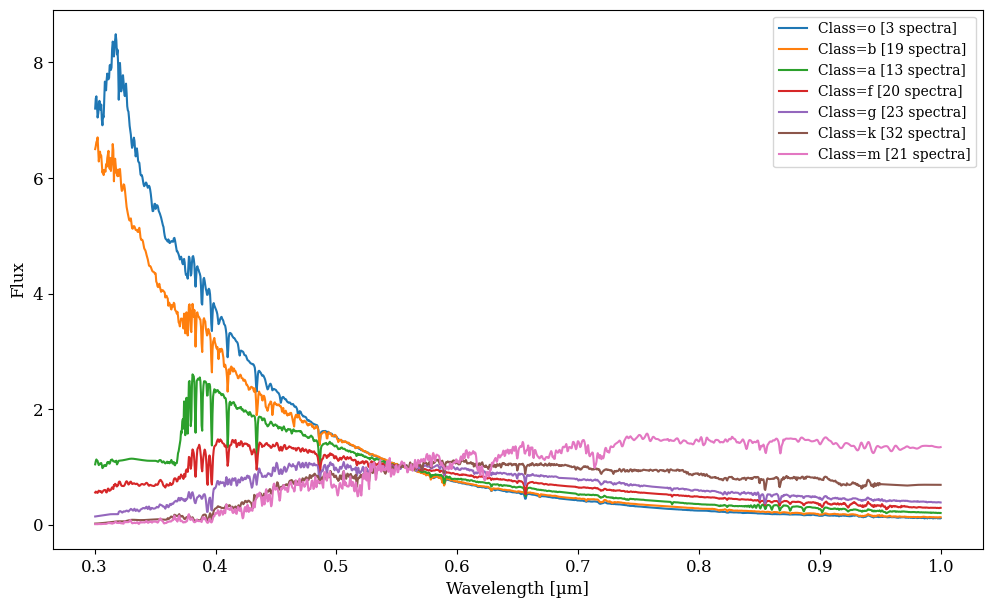

In [12]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,7))

MKclasses = ['o', 'b', 'a', 'f', 'g', 'k', 'm']
for MK in MKclasses:
    ii, = np.where(t_overview['SPType'] == MK)
    
    ax.plot(wave_opt/1e4, flux_opt[:, ii[0]], label='Class={0} [{1} spectra]'.format(MK, len(ii)))
    
ax.set_xlabel('Wavelength [µm]')
ax.set_ylabel('Flux')
ax.legend()

## Setting up for PCA

We now need to import the appropriate libraries for PCA.

In [13]:
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA

In [14]:
# This does automatic whitening
pca = PCA(n_components=10, whiten=False)

In [15]:
# This is the design matrix (note the transpose to adhere to the sklearn convention)
X = flux_opt.T.copy()

# And we want to calculate a mean spectrum too.
mean_spectrum = np.sum(X, axis=0)/len(X[:,0])

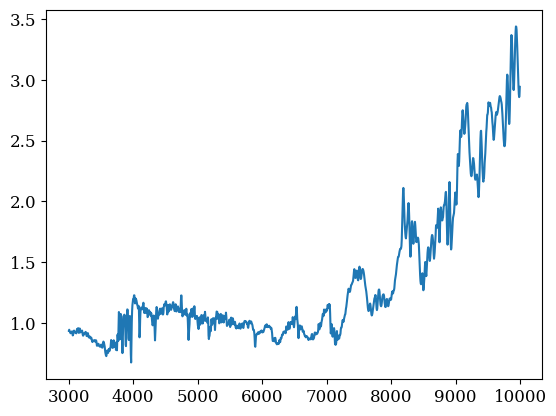

In [16]:
plt.plot(wave_opt, mean_spectrum)

In [17]:
X_zeromean = X.copy()
for i in range(131):
    X_zeromean[i, :] = X[i, :]-mean_spectrum

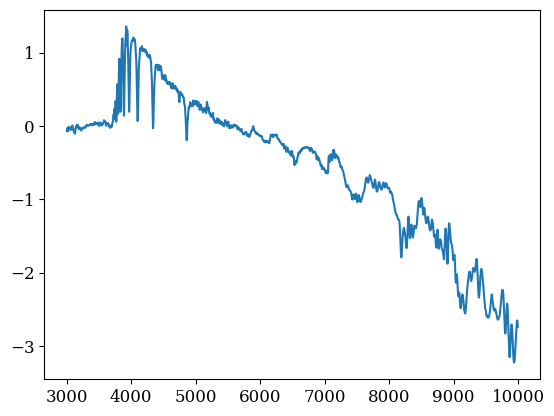

In [18]:
plt.plot(wave_opt, X_zeromean[5, :])

In [19]:
pca.fit(flux_opt.T)

PCA(n_components=10)

(0.0, 0.05)

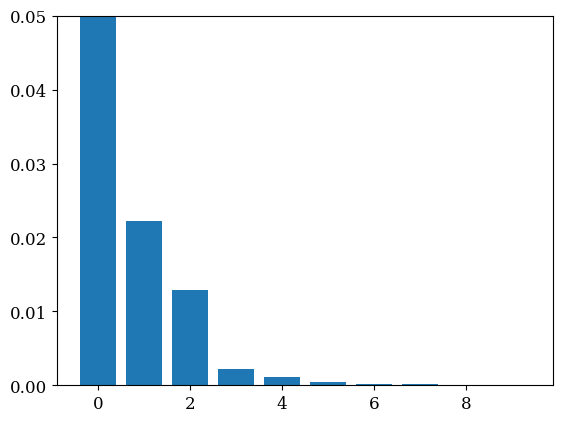

In [20]:
plt.bar(np.arange(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.ylim(0, 0.05)

## Looking at eigenspectra

Let us now see what the first few eigenspectra look like

In [21]:
pcs = pca.transform(X)

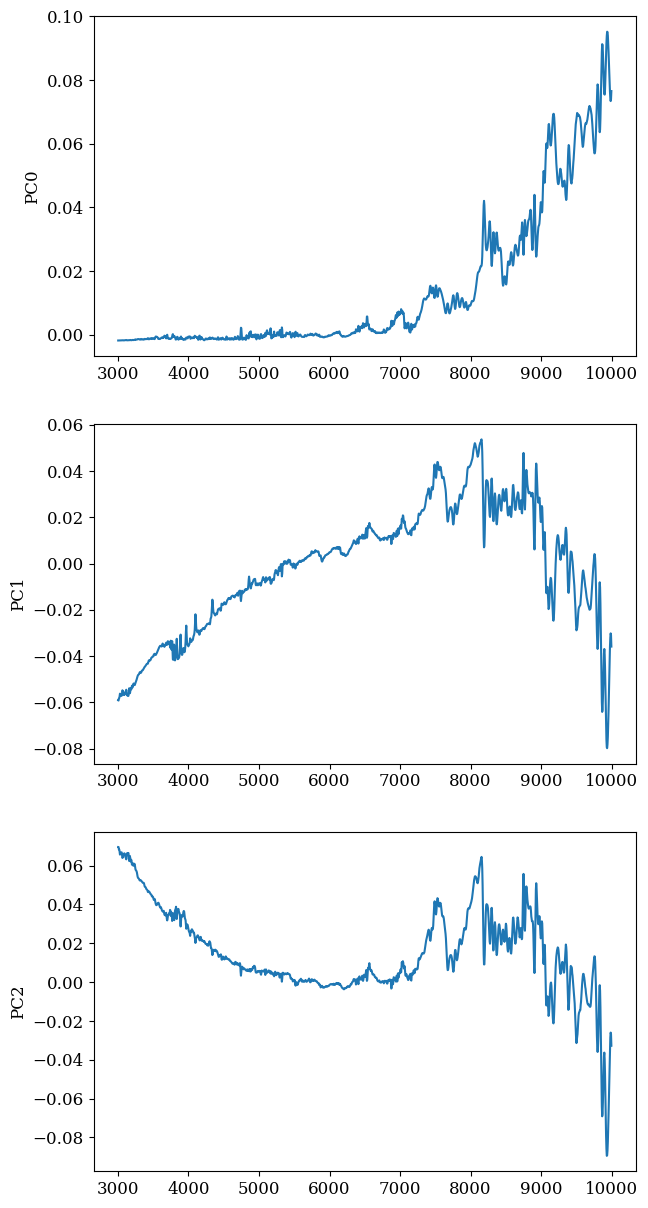

In [22]:
fig, ax = plt.subplots(nrows=3, figsize=(7, 15))
for i in range(3):
    ax[i].plot(wave_opt, pca.components_[i, :])
    ax[i].set_ylabel('PC{0}'.format(i))

## Visualise the principal components

For this we use the pcs that is calculated above. Here it is interesting to show this as a pair plot coloured by MKType and by luminosity class. 

In [23]:
dft = pd.DataFrame(pcs[:, 0:4], columns=('PC1', 'PC2', 'PC3', 'PC4'))

In [24]:
dft['type'] = t_overview['SPType']
dft['lumclass'] = t_overview['Lumclass']

In [25]:
#sns.pairplot(dft, hue='type', vars=('PC1', 'PC2', 'PC3', 'PC4'),
#             plot_kws={'s': 75, 'alpha': 0.5})

In [26]:
#sns.pairplot(dft, hue='lumclass', vars=('PC1', 'PC2', 'PC3', 'PC4'))

so it seems as if the luminosity class does not really correlate with anything very well while there is a correlation between MK class and various PCs. We can explore this further by using a 1D plot:

Text(0, 0.5, 'MK Type')

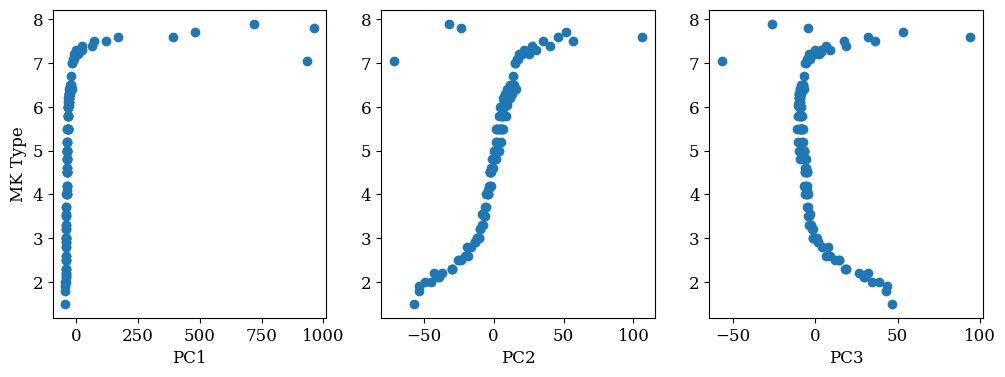

In [27]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

todo = ['PC1', 'PC2', 'PC3']
for i, t_pc in enumerate(todo):
    ax[i].scatter(dft[t_pc], t_overview['numtype'])
    ax[i].set_xlabel(t_pc)
    
ax[0].set_ylabel('MK Type')

Text(0, 0.5, 'Luminosity class')

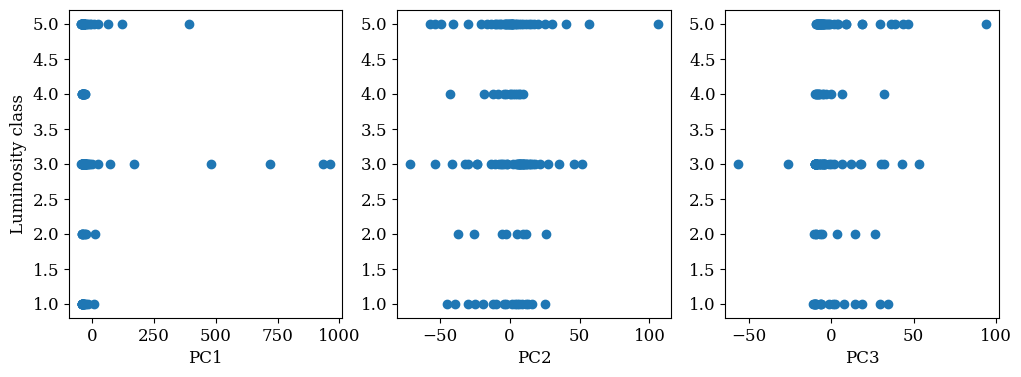

In [28]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

todo = ['PC1', 'PC2', 'PC3']
for i, t_pc in enumerate(todo):
    ax[i].scatter(dft[t_pc], t_overview['numlclass'])
    ax[i].set_xlabel(t_pc)
    
ax[0].set_ylabel('Luminosity class')

# Reconstruction of spectra

We now want to reconstruct spectra and see how well that works.

In [29]:
sp_depr = pca.inverse_transform(pcs)

In [30]:
sp_depr.shape

(131, 1399)

Text(0, 0.5, 'Flux')

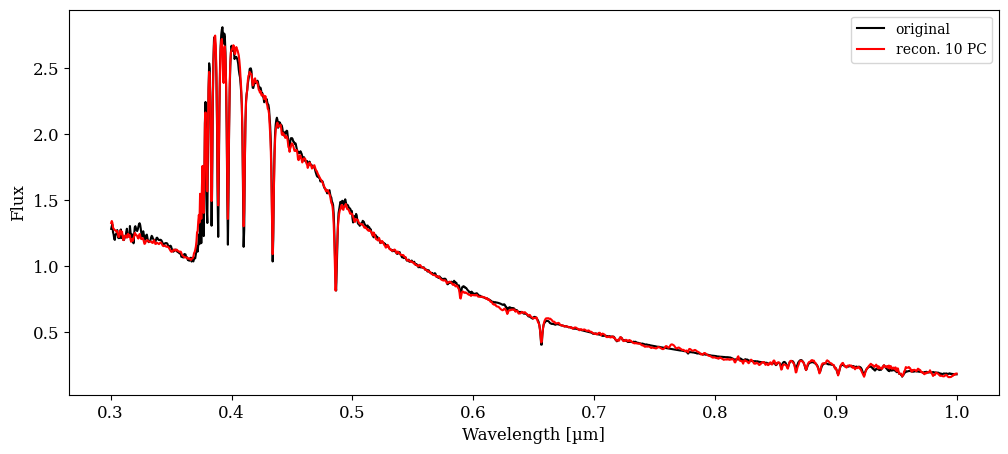

In [31]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(wave_opt/1e4, flux_opt[:, 30], color='black', label='original')
ax.plot(wave_opt/1e4, sp_depr[30, :], color='red', label='recon. 10 PC')
ax.legend()
ax.set_xlabel('Wavelength [µm]')
ax.set_ylabel('Flux')

It is here probably more useful to explore the residual plot.

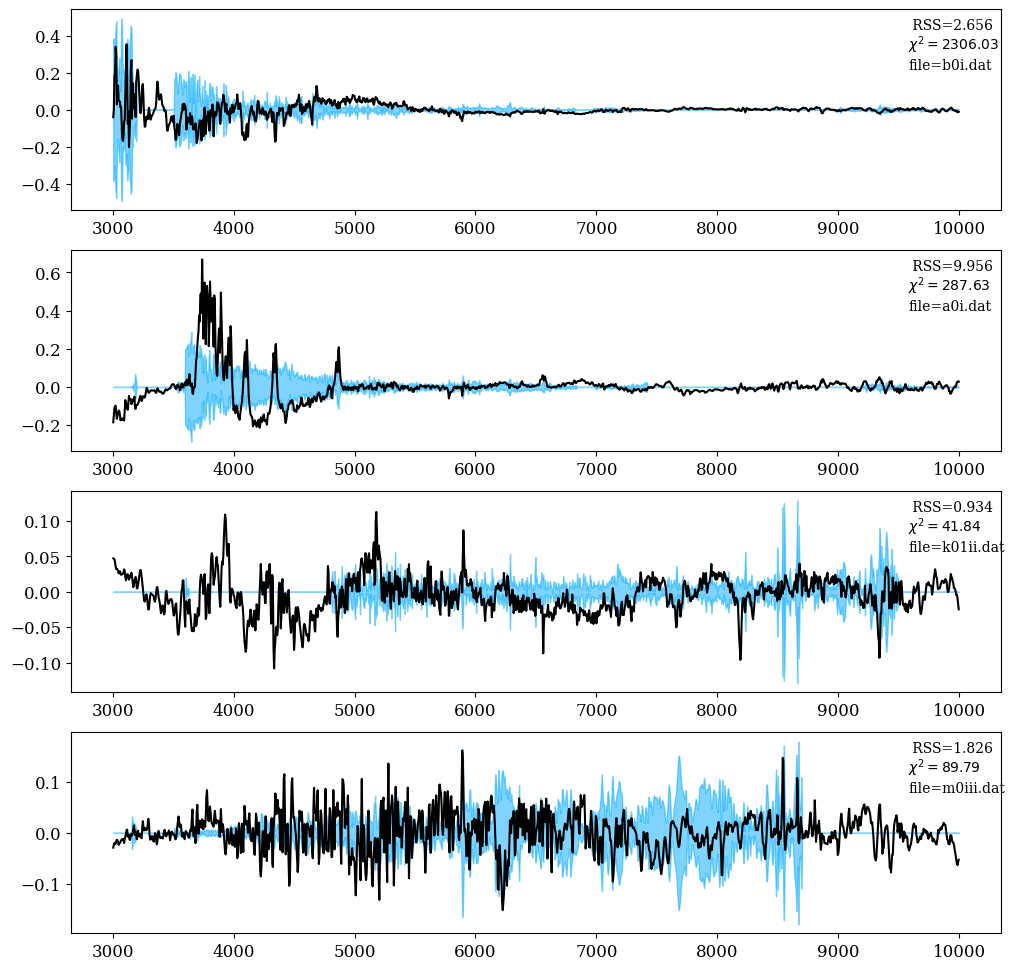

In [32]:
MKclasses = ['o', 'b', 'a', 'f', 'g', 'k', 'm']
MKclasses = ['b', 'a', 'k', 'm']
fig, ax = plt.subplots(figsize=(12, 12), nrows=len(MKclasses))
for i, MK in enumerate(MKclasses):
    ii, = np.where(t_overview['SPType'] == MK)
    ii = ii[0]
    diff = (flux_opt[:, ii]-sp_depr[ii, :])
    
    # Not every spectrum has an error estimate at all wavelengths.
    # To get a meaningful (ie. comparable) weighted RSS I want to normalise
    # by this.
    i_with_err, = np.where(dflux_opt[:, ii] > 0)
    n_with_err = len(i_with_err)
    rss = np.sum(diff**2)
    rss_w = np.nansum((diff[i_with_err]/dflux_opt[i_with_err, ii])**2)/n_with_err
    
    ax[i].plot(wave_opt, diff, color='black')
    ax[i].fill_between(wave_opt, dflux_opt[:, ii], -dflux_opt[:, ii],
                       color='#00aaff', alpha=0.5)
    ax[i].text(0.9, 0.9, ' RSS={0:.3f}'.format(rss), transform=ax[i].transAxes)
    ax[i].text(0.9, 0.8, r'$\chi^2={0:.2f}$'.format(rss_w), transform=ax[i].transAxes)
    ax[i].text(0.9, 0.7, 'file={0}'.format(t_overview['file'][ii][2:]), transform=ax[i].transAxes)

# Determining the number of components needed

This requires some more calculation. Let us approach this from a cross-validation point of view. In that case we need to set up a cross-validation run, loop over this and run PCA with varying numbers of components and calculate the RSS over the whole sample.

In [33]:
from sklearn.model_selection import KFold

X = flux.T
def do_one_cv_pca(X, n_components, n_splits=10):
    # Create folds for N data points in n_folds:
        
    kf = KFold(n_splits=n_splits)
    RSS = 0.0
    for train, test in kf.split(X):
        x_train = X[train, :]
        x_test = X[test, :]
    
        # Calculate PCA on the training sample.
        # This does automatic whitening
        pca = PCA(n_components=n_components, whiten=True)
        pca.fit(x_train)
    
        # Use this to reconstruct the test sample
        #pcs = pca.transform(x_test)
        #sp_depr = pca.inverse_transform(pcs)
    
        #RSS_this = np.sum((x_test-sp_depr)**2)
        RSS_this = pca.score(x_test)
        RSS += RSS_this
    
    return RSS


def do_multiple_n_comp(X):
    
    n_comps = np.arange(1, 50)
#    n_comps = np.arange(1, 120, 5)
    N = len(n_comps)
    RSS = np.zeros(N)
    for i, n_comp in enumerate(n_comps):
        print("Doing {0:2d}".format(i))
        RSS[i] = do_one_cv_pca(X, n_comp)
        
    return RSS, n_comps

In [34]:
RSS = do_one_cv_pca(X, 5)

In [35]:
# RSSes, n_comps = do_multiple_n_comp(X)

In [36]:
# plt.plot(n_comps, np.exp(RSSes/1e7))

In [37]:
t_overview

SPType,Lumclass,Metal,numtype,metflag,numlclass,file
str1,str3,str3,float64,int64,int64,str12
a,i,uk,3.0,1,1,uka0i.dat
a,iii,uk,3.0,1,3,uka0iii.dat
a,iv,uk,3.0,1,4,uka0iv.dat
a,v,uk,3.0,1,5,uka0v.dat
a,i,uk,3.2,1,1,uka2i.dat
a,v,uk,3.2,1,5,uka2v.dat
a,iii,uk,3.3,1,3,uka3iii.dat
a,v,uk,3.3,1,5,uka3v.dat
a,iv,uk,3.55,1,4,uka47iv.dat
